In [1]:
import matplotlib.pyplot as plt
from helpers.cm26 import DatasetCM26, remesh
from helpers.computational_tools import select_NA, select_Pacific, StateFunctions, compare
from helpers.ann_tools import ANN, import_ANN, minibatch, export_ANN
import torch
import torch.optim as optim
import numpy as np
from time import time
import json
%load_ext autoreload
%autoreload 3

In [2]:
ds = DatasetCM26()

In [3]:
ann_Txy = ANN([27, 20, 1])
ann_Txx_Tyy = ANN([27, 20, 2])
log_dict = {}
# ann_Txy = import_ANN('trained_models/ANN_Txy_ZB.nc')
# ann_Txx_Tyy = import_ANN('trained_models/ANN_Txx_Tyy_ZB.nc')

In [4]:
num_epochs=2000

all_parameters = list(ann_Txy.parameters()) + list(ann_Txx_Tyy.parameters())
optimizer = optim.Adam(all_parameters, lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
        milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)  

t_s = time()

for epoch in range(num_epochs):
    t_e = time()
    
    training_dataset = ds.sample_epoch(time=np.random.randint(6950)) # Approximately 19 years for training
    testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035)) # Approximately 3 years for testing
    print(f'---------- Epoch {epoch} ------------\n')
    
    for factor in [2,4,6,10,20]:
        ############# Training step ################
        
        optimizer.zero_grad()
        
        batch = training_dataset[factor]
        prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
        ANNx = prediction['ZB20u']
        ANNy = prediction['ZB20v']
        SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
        SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)
        
        SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())
        
        MSE_train = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        MSE_train.backward()
        optimizer.step()
        
        ############ Testing step ##################
        with torch.no_grad():
            batch = testing_dataset[factor]
            prediction = batch.state.Apply_ANN(ann_Txy, ann_Txx_Tyy)
            ANNx = prediction['ZB20u']
            ANNy = prediction['ZB20v']
            SGSx = torch.tensor(batch.data.SGSx.values).type(torch.float32)
            SGSy = torch.tensor(batch.data.SGSy.values).type(torch.float32)

            SGS_norm = 1. / torch.sqrt((SGSx**2 + SGSy**2).mean())

            MSE_test = ((ANNx*SGS_norm-SGSx*SGS_norm)**2 + (ANNy*SGS_norm-SGSy*SGS_norm)**2).mean()
        
        print(f'Factor: {factor}. '+'MSE train/test: [%.6f, %.6f]' % (float(MSE_train.data), float(MSE_test.data)))
        ########### Saving history of losses ############
        log_dict[f'epoch-{epoch+1}-factor-{factor}'] = dict(MSE_train=float(MSE_train.data),MSE_test=float(MSE_test.data))
        ######## Freeing memory ############
        del training_dataset[factor].data
        del training_dataset[factor].param
        del testing_dataset[factor].data
        del testing_dataset[factor].param
    t = time()
    print('Epoch time/Remaining time in seconds: [%d/%d]' % (t-t_e, (t-t_s)*(num_epochs/(epoch+1)-1)))
    scheduler.step()
    
    
    if (epoch+1) % 50 == 0:
        export_ANN(ann_Txy, input_norms=torch.ones(27), output_norms=torch.ones(1), 
           filename=f'trained_models/ANN_CM26/Txy_epoch_{epoch+1}.nc')
        export_ANN(ann_Txx_Tyy, input_norms=torch.ones(27), output_norms=torch.ones(2), 
           filename=f'trained_models/ANN_CM26/Txx_Tyy_epoch_{epoch+1}.nc')
        with open(f'trained_models/ANN_CM26/log_dict_epoch_{epoch+1}', 'w') as file:
            json.dump(log_dict, file)

---------- Epoch 0 ------------

Factor: 2. MSE train/test: [15.529391, 16.538153]
Factor: 4. MSE train/test: [12.036655, 11.385144]
Factor: 6. MSE train/test: [9.688353, 8.769253]
Factor: 10. MSE train/test: [6.536051, 5.819148]
Factor: 20. MSE train/test: [3.021098, 2.324247]
Epoch time/Remaining time in seconds: [17/34511]
---------- Epoch 1 ------------

Factor: 2. MSE train/test: [10.675262, 11.805842]
Factor: 4. MSE train/test: [7.461082, 7.711838]
Factor: 6. MSE train/test: [6.145721, 6.379466]
Factor: 10. MSE train/test: [4.169394, 4.376135]
Factor: 20. MSE train/test: [1.913505, 2.402759]
Epoch time/Remaining time in seconds: [16/34178]
---------- Epoch 2 ------------

Factor: 2. MSE train/test: [7.973310, 8.879717]
Factor: 4. MSE train/test: [5.545613, 6.033548]
Factor: 6. MSE train/test: [4.695931, 4.647157]
Factor: 10. MSE train/test: [3.560944, 3.450822]
Factor: 20. MSE train/test: [1.570431, 1.599309]
Epoch time/Remaining time in seconds: [16/33901]
---------- Epoch 3 ---

(0.1, 1)

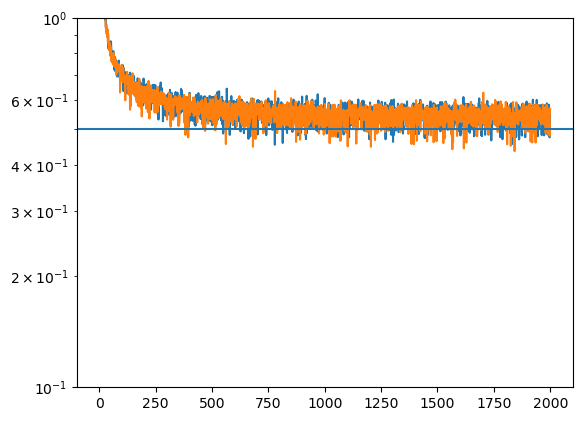

In [9]:
import json
import matplotlib.pyplot as plt

with open('trained_models/ANN_CM26/log_dict_epoch_2000') as f:
    data = json.load(f)
    
    plt.plot([data[f'epoch-{j}-factor-6']['MSE_train'] for j in range(1,2001)], label='Train')
plt.plot([data[f'epoch-{j}-factor-6']['MSE_test'] for j in range(1,2001)], label='Test')
plt.yscale('log')
plt.axhline(y=0.5)
plt.ylim([1e-1,1])

# Testing predictions

In [23]:
ann_Txy = import_ANN('trained_models/ANN_CM26/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')

Correlation: 0.6727578021163761
Relative Error: 0.8177526484862203
R2 =  0.45257025121580896
R2 max =  0.45260117466912175
Optinal scaling: 1.0083347173300992
Nans: 0
Correlation: 0.6549781257963257
Relative Error: 0.8257140572990536
R2 =  0.4289478218534346
R2 max =  0.4289849644526933
Optinal scaling: 1.009392368598232
Nans: 0
Correlation: 0.5887898223699257
Relative Error: 0.8744741181815331
R2 =  0.3450057875719419
R2 max =  0.34665565723777925
Optinal scaling: 1.0741003997857796
Nans: 0


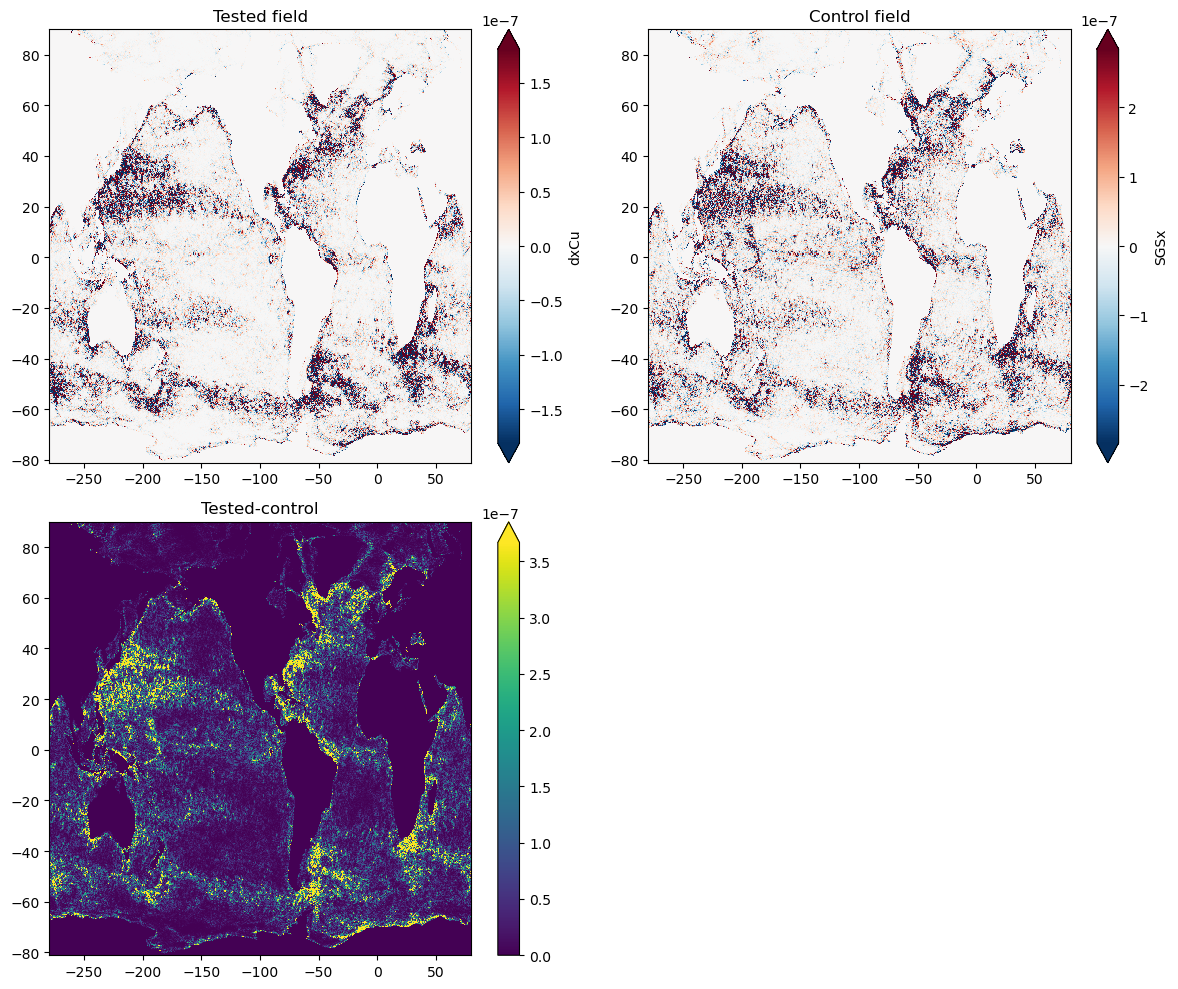

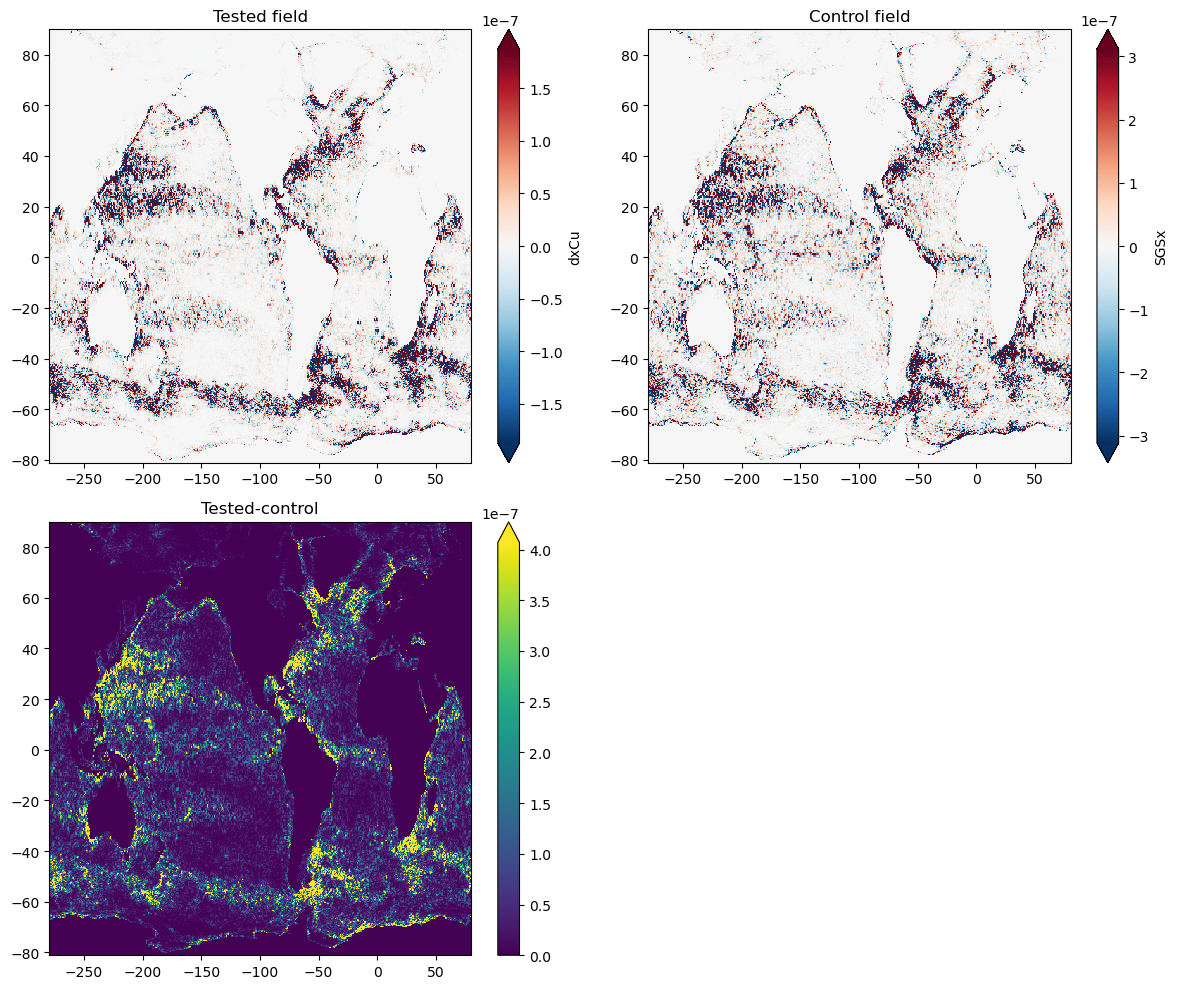

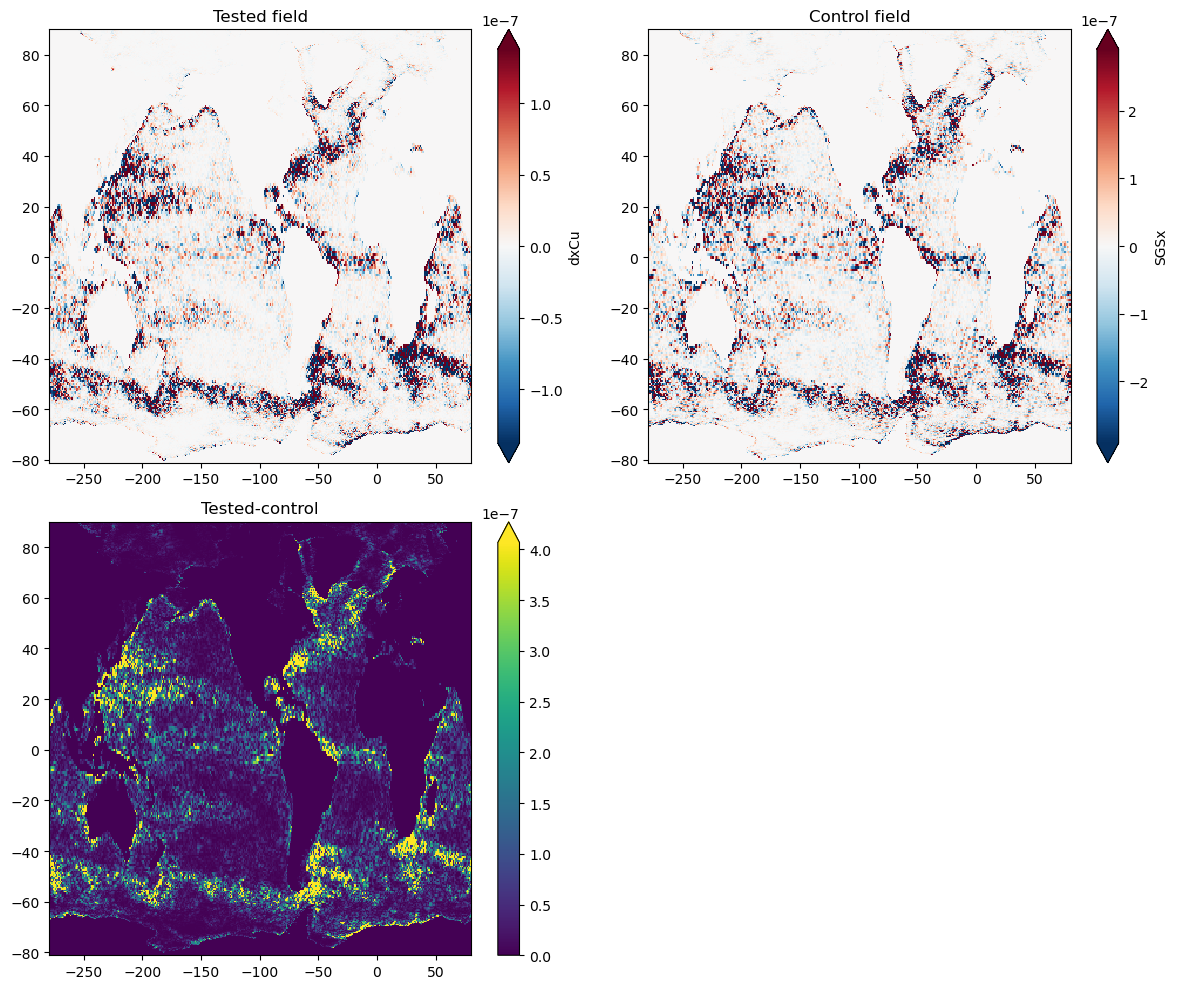

In [28]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    compare(testing_dataset[factor].state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20u'], data.SGSx, selector=lambda x: x)

Correlation: 0.684166227560151
Relative Error: 0.8214145222109028
R2 =  0.4680055430471054
R2 max =  0.46808044124211357
Optinal scaling: 0.9875084523167279
Nans: 0
Correlation: 0.6836627880788235
Relative Error: 0.8173833696992527
R2 =  0.4673428532871817
R2 max =  0.4673961354763849
Optinal scaling: 1.0107922092549089
Nans: 0
Correlation: 0.6316163983288413
Relative Error: 0.8657098570202555
R2 =  0.39626336646191884
R2 max =  0.3989454161250313
Optinal scaling: 1.0893162880050982
Nans: 0


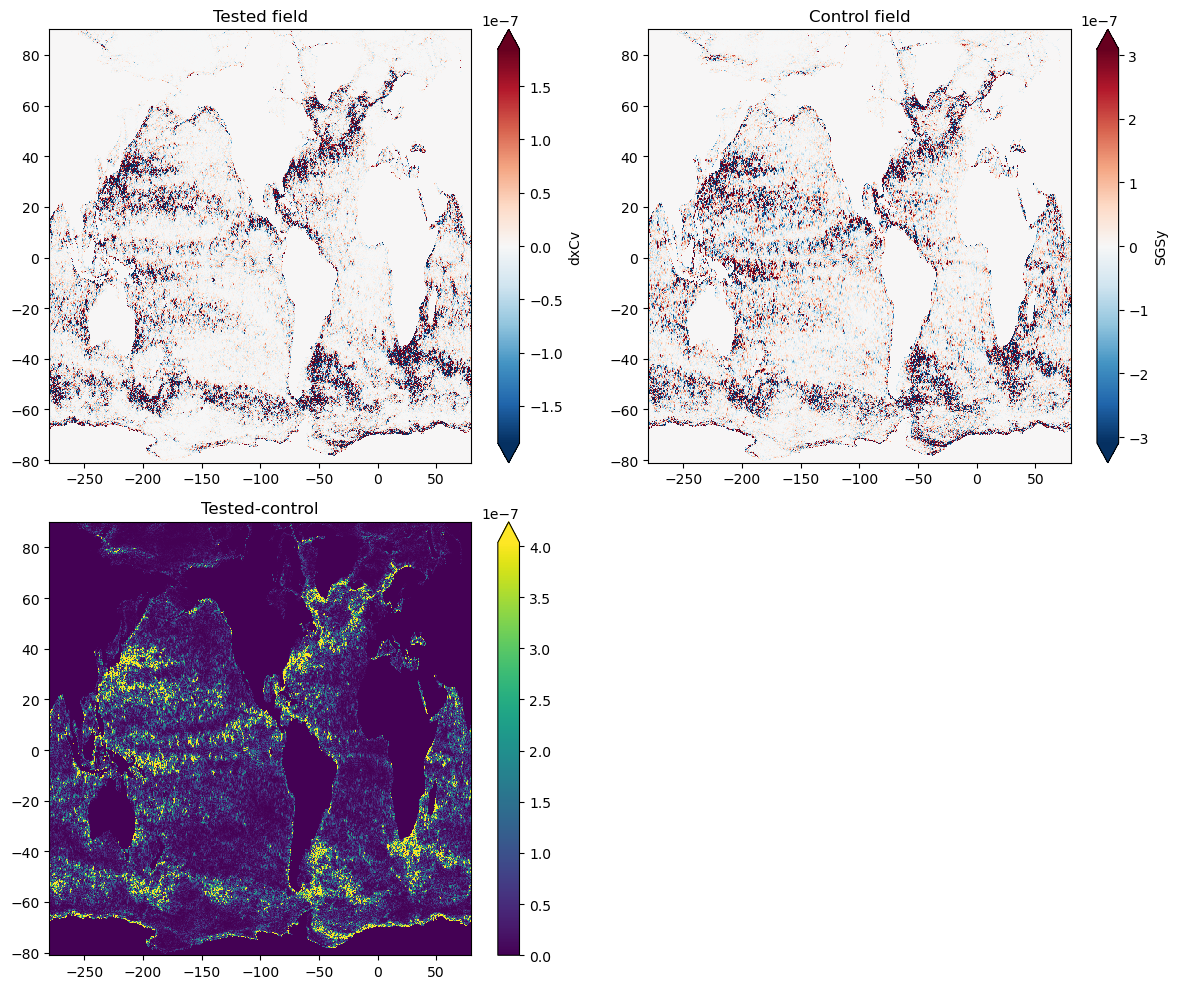

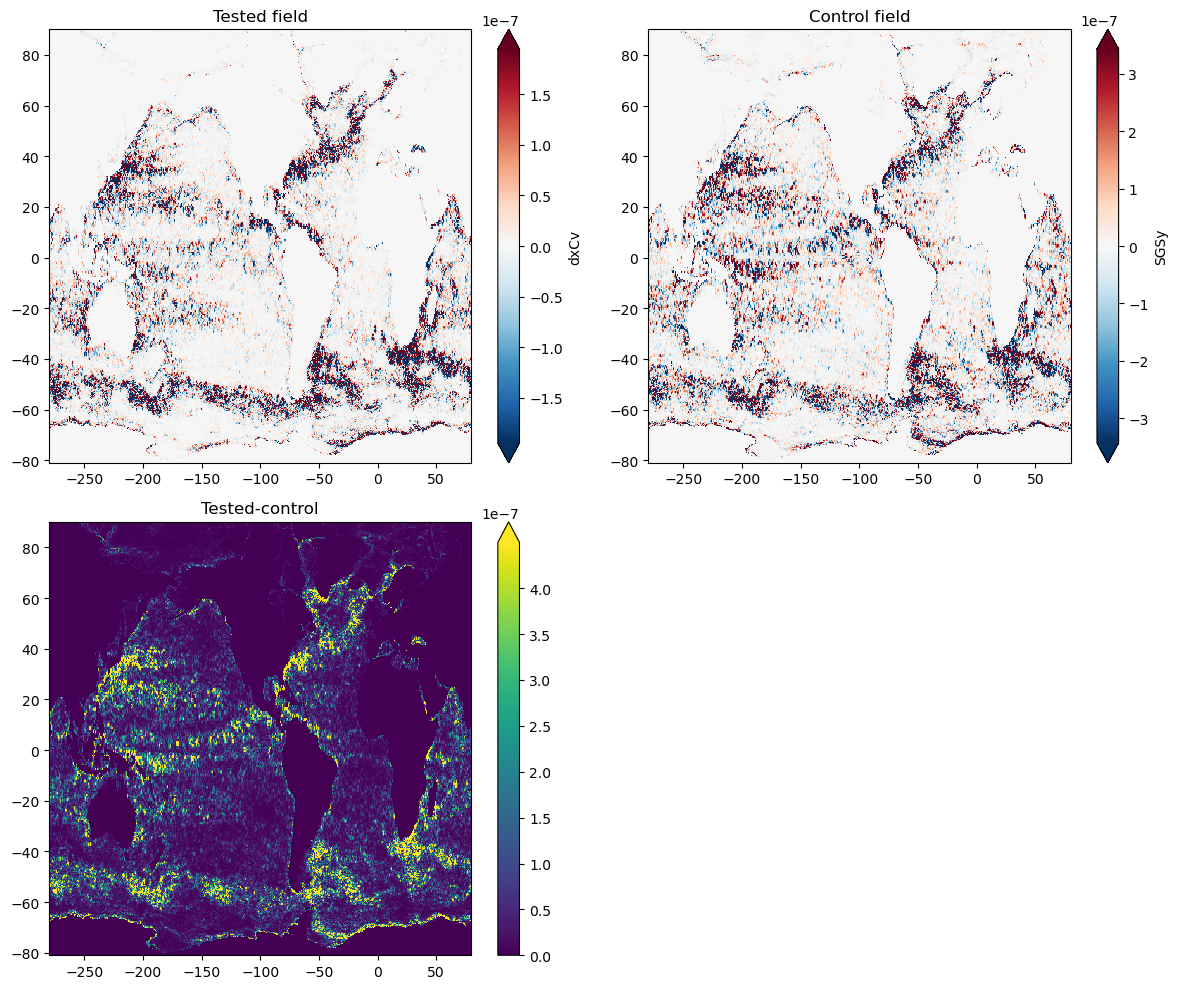

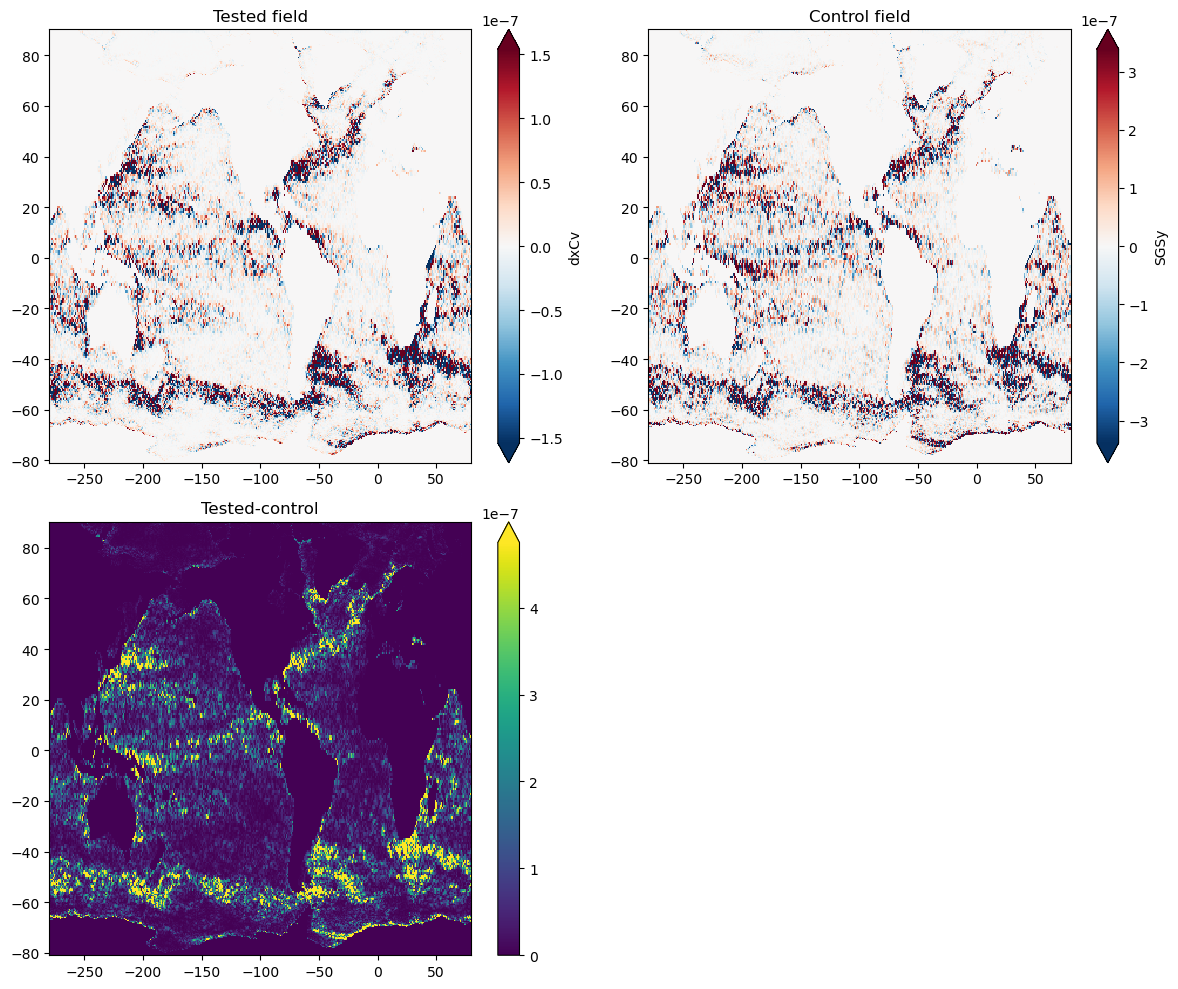

In [27]:
testing_dataset = ds.sample_epoch(time=np.random.randint(6950,8035))
for factor in [4,6,10]:
    data = testing_dataset[factor].data
    compare(testing_dataset[factor].state.ANN(ann_Txy, ann_Txx_Tyy)['ZB20v'], data.SGSy, selector= lambda x: x)